In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

BATCH_SIZE = 16
IMAGE_SIZE = (240, 240)

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
def get_train_val_dataset():
	# Get train dataset
	train_ds = keras.utils.image_dataset_from_directory(
		directory = "Defungi Split/Train",
		batch_size = BATCH_SIZE,
		image_size = IMAGE_SIZE,
		seed=27
		)

	# Get validation dataset
	val_ds = keras.utils.image_dataset_from_directory(
		directory = "Defungi Split/Validation",
		batch_size = BATCH_SIZE,
		image_size = IMAGE_SIZE,
		seed=27
		)
	
	return train_ds, val_ds

In [3]:
def get_test_dataset():
	# Get test dataset
	test_ds = keras.utils.image_dataset_from_directory(
		directory = "Defungi Split/Test",
		batch_size = BATCH_SIZE,
		image_size = IMAGE_SIZE,
		seed=27
		)

	return test_ds

In [4]:
def get_base_model(num_classes, checkpoint_path: str = None):
	# Import pre-trained model
	os.environ['TFHUB_CACHE_DIR'] = 'tf_cache'
	feature_extractor_layer = hub.KerasLayer(
		"https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
		input_shape=IMAGE_SIZE+(3,),
		trainable=False)
	
	# Create model
	model = keras.models.Sequential([
		keras.layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
		feature_extractor_layer,
		keras.layers.Flatten(),
		keras.layers.Dense(num_classes)])
	model.compile(optimizer='adam',
				loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
				metrics=['accuracy'])

	# Load checkpoint if any
	if checkpoint_path:
		model.load_weights(checkpoint_path)

	return model

In [5]:
def get_custom_model(num_classes, checkpoint_path: str = None):
	# Import pre-trained model
	os.environ['TFHUB_CACHE_DIR'] = 'tf_cache'
	feature_extractor_layer = hub.KerasLayer(
		"https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
		input_shape=IMAGE_SIZE+(3,),
		trainable=False)
	
	# Create model
	model = keras.models.Sequential([
		keras.layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
		feature_extractor_layer,
		keras.layers.Dropout(0.2),
		keras.layers.Flatten(),
		keras.layers.Dense(128, activation='relu'),
		keras.layers.Dense(num_classes)])
	model.compile(optimizer='adam',
				loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
				metrics=['accuracy'])

	# Load checkpoint if any
	if checkpoint_path:
		model.load_weights(checkpoint_path)

	return model

In [6]:
def get_custom_model_2(num_classes, checkpoint_path: str = None):
	# Import pre-trained model
	os.environ['TFHUB_CACHE_DIR'] = 'tf_cache'
	feature_extractor_layer = hub.KerasLayer(
		"https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
		input_shape=IMAGE_SIZE+(3,),
		trainable=False)
	
	# Create model
	model = keras.models.Sequential([
		keras.layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
		feature_extractor_layer,
		keras.layers.Dropout(0.2),
		keras.layers.Flatten(),
		keras.layers.Dense(128, activation='relu'),
		keras.layers.Dense(128, activation='relu'),
		keras.layers.Dense(num_classes)])
	model.compile(optimizer='adam',
				loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
				metrics=['accuracy'])

	# Load checkpoint if any
	if checkpoint_path:
		model.load_weights(checkpoint_path)

	return model

In [7]:
def train_model(model, train_dataset, validation_dataset, epochs = 50, initial_epoch = 0, checkpoint_folder: str = None, log_file: str = None):
	
	# Create callbacks
	callbacks = []
	callbacks.append(keras.callbacks.EarlyStopping(patience=5, start_from_epoch=initial_epoch, restore_best_weights=True))
	if checkpoint_folder:
		checkpoint_path = checkpoint_folder + "/saved-model.ckpt"
		callbacks.append(keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True))
	if log_file:
		callbacks.append(keras.callbacks.CSVLogger(log_file, separator=',', append=True))

	# Train the model
	model.fit(
		train_dataset,
		validation_data=validation_dataset,
		initial_epoch=initial_epoch,
		epochs=epochs,
		callbacks=callbacks,
		use_multiprocessing=True
	)

# Training

In [8]:
train_ds, val_ds = get_train_val_dataset()

class_names = train_ds.class_names
num_classes = len(class_names)

# Configure datasets for optimization
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6377 files belonging to 5 classes.
Found 1364 files belonging to 5 classes.


Base Model

In [10]:
# Create base model
base_model = get_base_model(num_classes, r"models\base-model\checkpoints\cp-0050.ckpt")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              6931124   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 6,937,529
Trainable params: 6,405
Non-trainable params: 6,931,124
_________________________________________________________________


In [60]:
# Train base model
# train_model(base_model, train_ds, val_ds, 50, 0, 5, r"models\base-model\checkpoints", r"models\base-model\logs\history.csv")

Custom Model

In [11]:
# Create custom model
custom_model = get_custom_model(num_classes, r"models\custom-model\checkpoints\cp-0050.ckpt")
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              6931124   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7,095,737
Trainable params: 164,613
Non-

In [62]:
# Train custom model
# train_model(custom_model, train_ds, val_ds, 50, 0, 5, r"models\custom-model\checkpoints", r"models\custom-model\logs\history.csv")

Custom Model 2

In [12]:
# Create custom model 2
# custom_model_2 = get_custom_model_2(num_classes)
custom_model_2 = get_custom_model_2(num_classes, r"models\custom-model-2\checkpoints\saved-model.ckpt")
custom_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1280)              6931124   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 5)                

In [64]:
# Train custom model 2
# train_model(custom_model_2, train_ds, val_ds, 50, 0, 5, r"models\custom-model-2\checkpoints", r"models\custom-model-2\logs\history.csv")

# Visualize Training Results

Base Model

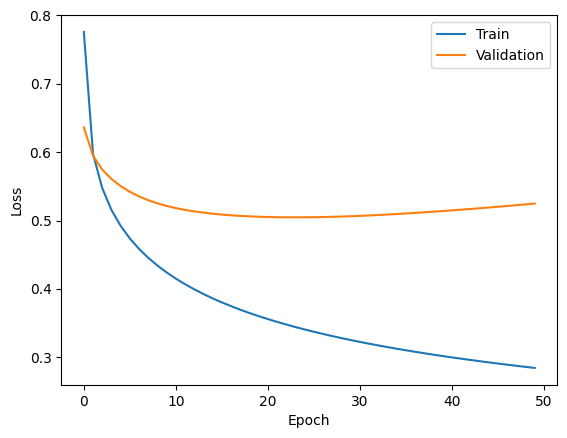

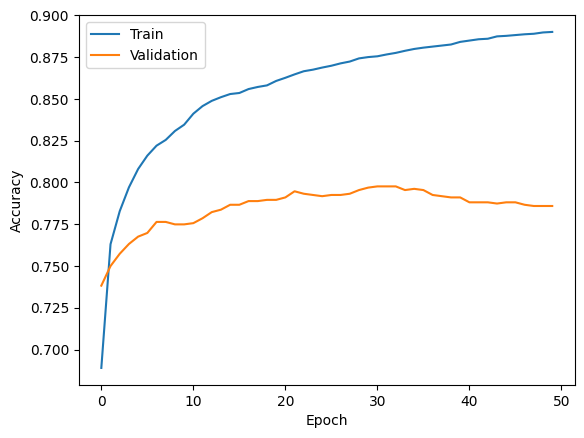

In [13]:
history_base = pd.read_csv(r"models\base-model\logs\history.csv")

plt.plot(history_base['loss'])
plt.plot(history_base['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history_base['accuracy'])
plt.plot(history_base['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [28]:
history_base.iloc[-1]

epoch           49.000000
accuracy         0.890074
loss             0.284450
val_accuracy     0.785924
val_loss         0.524863
Name: 49, dtype: float64

Custom Model

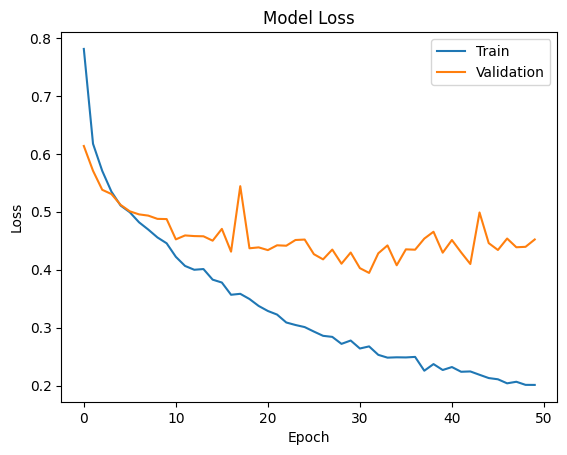

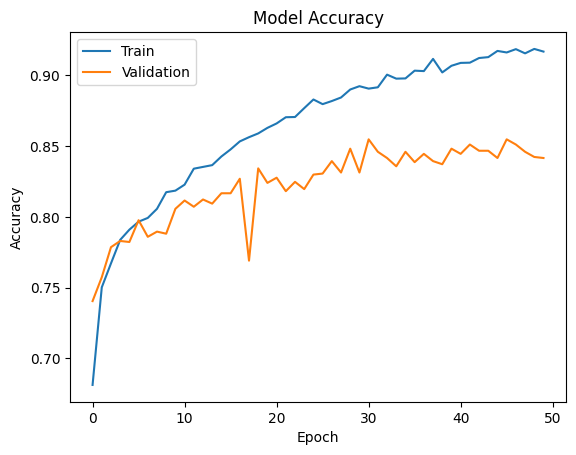

In [17]:
history_custom = pd.read_csv(r"models\custom-model\logs\history.csv")

plt.plot(history_custom['loss'])
plt.plot(history_custom['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history_custom['accuracy'])
plt.plot(history_custom['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [27]:
history_custom.iloc[-1]

epoch           49.000000
accuracy         0.916889
loss             0.201073
val_accuracy     0.841642
val_loss         0.452184
Name: 49, dtype: float64

Custom Model 2

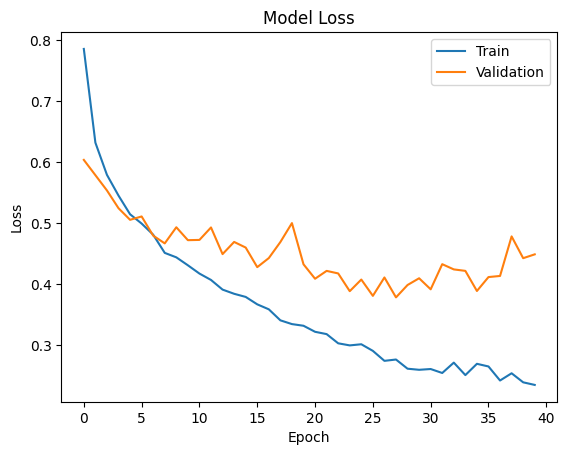

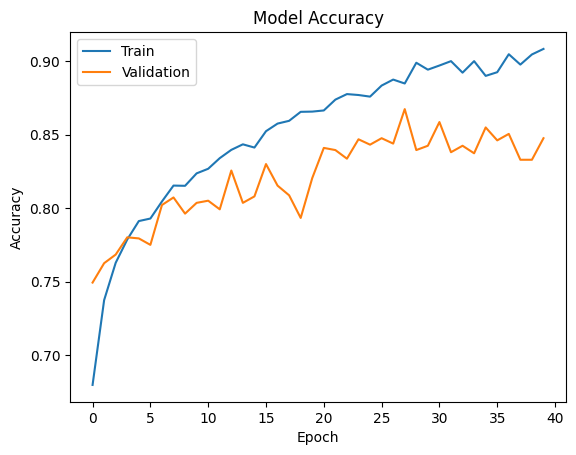

In [20]:
history_custom_2 = pd.read_csv(r"models\custom-model-2\logs\history.csv")

plt.plot(history_custom_2['loss'])
plt.plot(history_custom_2['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history_custom_2['accuracy'])
plt.plot(history_custom_2['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [26]:
history_custom_2.iloc[-6]

epoch           34.000000
accuracy         0.889917
loss             0.269648
val_accuracy     0.854839
val_loss         0.388914
Name: 34, dtype: float64

# Test Model

In [72]:
test_ds = get_test_dataset()
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1373 files belonging to 5 classes.


In [73]:
print("Base Model")
base_results = base_model.evaluate(test_ds)
print("Loss:", base_results[0])
print("Accuracy:", base_results[1])

Base Model
86/86 [==============================] - 174s 2s/step - loss: 0.4903 - accuracy: 0.8004
Loss: 0.4902912676334381
Accuracy: 0.8004369735717773


In [74]:
print("Custom Model")
custom_results = custom_model.evaluate(test_ds)
print("Loss:", custom_results[0])
print("Accuracy:", custom_results[1])

Custom Model
86/86 [==============================] - 202s 2s/step - loss: 0.4017 - accuracy: 0.8631
Loss: 0.4017150402069092
Accuracy: 0.8630735874176025


In [75]:
print("Custom Model 2")
custom_2_results = custom_model_2.evaluate(test_ds)
print("Loss:", custom_2_results[0])
print("Accuracy:", custom_2_results[1])

Custom Model 2
86/86 [==============================] - 222s 3s/step - loss: 0.3897 - accuracy: 0.8653
Loss: 0.3897150754928589
Accuracy: 0.8652585744857788
